In [1]:
# --- 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
prompt_img_path = "/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train/M5Sandstorm__part_4.png"

In [26]:
target_img_path = "/disk3/eric/dataset/VISION_SOFS/WEAPON_4/test_splits/test1_part_17.png"

In [27]:
prompt_img = Image.open(prompt_img_path)
target_img = Image.open(target_img_path)

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/train/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/test_splits/test1_part_17.png


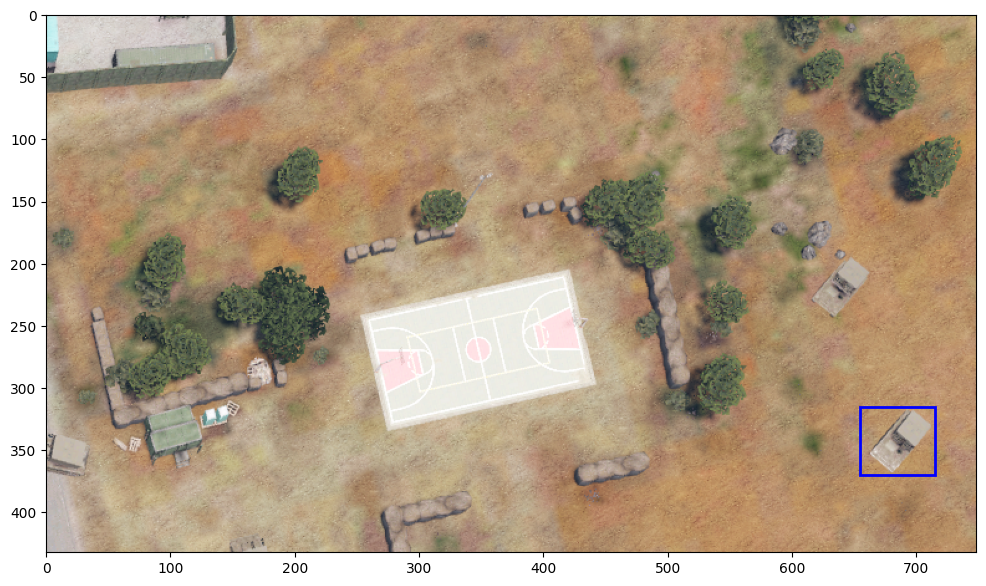

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import matplotlib.image as mpimg

# Load the image  
# # Replace with your image file path
img = prompt_img

# Define rectangle coordinates in [x1, y1, x2, y2] format
rects = [[655, 315, 715, 370]]
x1, y1, x2, y2 = rects[0]

# Calculate width and height from the coordinates
width = x2 - x1
height = y2 - y1

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12,12))

# Display the image
ax.imshow(img)

# Create a rectangle and add it to the plot
rectangle = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rectangle)

#------ crop and save
cropped_img = img.crop((x1, y1, x2, y2))
cropped_img.save(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/query/query.png")  


# Set the limits of the plot to fit the image
ax.set_xlim(0, img.size[0])
ax.set_ylim(img.size[1], 0)  # Invert the y-axis to match image coordinates

# Display the plot with the rectangle overlay
plt.show()

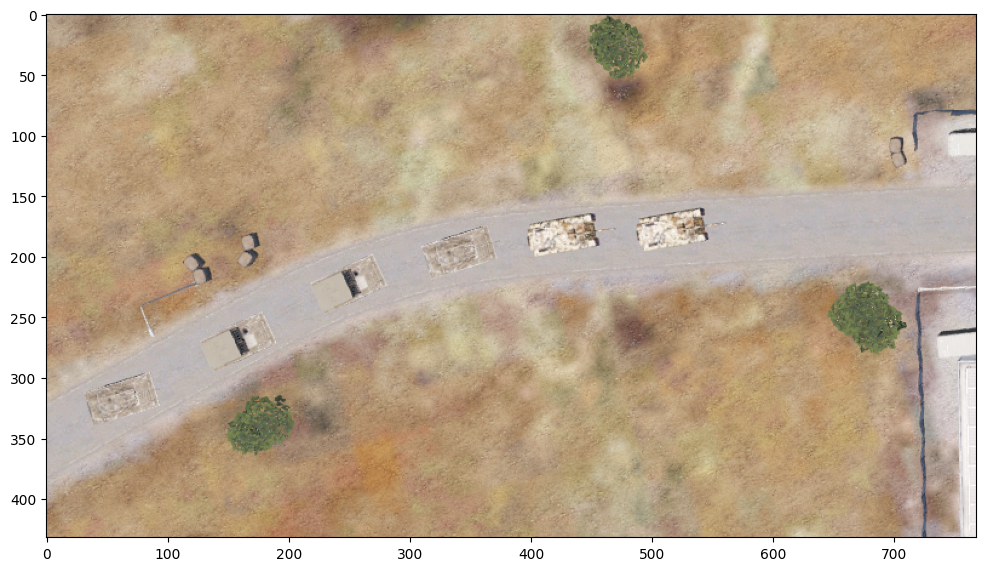

In [45]:
plt.figure(figsize=(12,12))
plt.imshow(target_img)

In [46]:
#--- generic_infernece.sh 코드 돌려야함. 

In [9]:
#--- load result 

In [47]:
result_path = "/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result/result.txt"

In [48]:
import numpy as np
result_np = np.loadtxt(result_path, delimiter=",")

In [49]:
result_np[0]

array([309.52301025, 174.98678589, 372.01959229, 218.17341614])

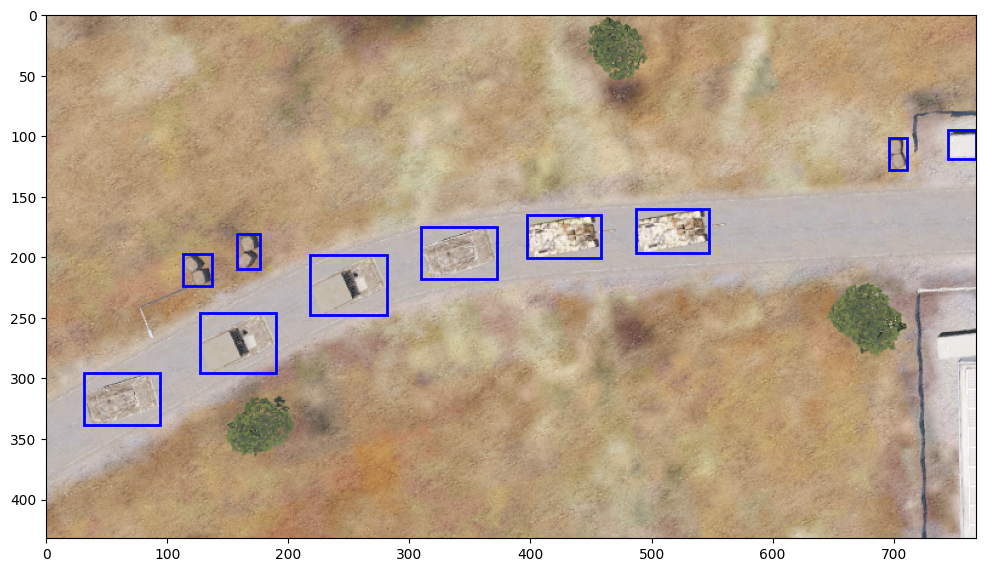

In [50]:
'''
Crop the inference result 

'''

img = target_img
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12,12))
# Display the image
for i,box in enumerate(result_np):
    x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
    width = x2 - x1
    height = y2 - y1
    rectangle = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rectangle)
    cropped_img = target_img.crop((x1, y1, x2, y2))
    #cropped_img.save(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop/cropped_box_{i}.png")  

# Set the limits of the plot to fit the image
ax.set_xlim(0, img.size[0])
ax.set_ylim(img.size[1], 0)  # Invert the y-axis to match image coordinates
# Display the plot with the rectangle overlay
ax.imshow(img)
plt.show()

In [51]:
import numpy as np 

In [52]:
np.__version__

'1.24.4'

In [53]:
'''
Find best image retrieval 
'''

from datasets import load_dataset
data = load_dataset("imagefolder", data_dir="/disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face", split="test")
#data = load_dataset("not-lain/pokemon",split="train")

/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
data

Dataset({
    features: ['image'],
    num_rows: 10
})

In [55]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification # or you can use CLIPProcessor, CLIPModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14", device_map = device)

/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [56]:
def embed(batch):
    pixel_values = processor(images = batch["image"], return_tensors="pt")['pixel_values']
    pixel_values = pixel_values.to(device)
    img_emb = model.get_image_features(pixel_values)
    batch["embeddings"] = img_emb
    return batch

In [57]:
embedded_dataset = data.map(embed, batched=True, batch_size=10)

In [58]:
dataset = embedded_dataset.add_faiss_index("embeddings")

100%|██████████| 1/1 [00:00<00:00, 3421.13it/s]


In [59]:
import numpy as np

def search(query: str, k: int = 10 ):
    """a function that embeds a new image and returns the most probable results"""

    pixel_values = processor(images = query, return_tensors="pt")['pixel_values'] # embed new image
    pixel_values = pixel_values.to(device)
    img_emb = model.get_image_features(pixel_values)[0] # because it's a single element
    img_emb = img_emb.cpu().detach().numpy() # convert to numpy because the datasets library does not support torch vectors

    scores, retrieved_examples = dataset.get_nearest_examples( # retrieve results
        "embeddings", img_emb, # compare our new embedded image with the dataset embeddings
        k=k # get only top k results
    )

    result = {
        'scores' : scores,
        'images' : retrieved_examples
        
    }
    return result


In [60]:
from loadimg import load_img

In [61]:
image = load_img("/disk3/eric/dataset/VISION_SOFS/WEAPON_4/query/query.png")
#image = load_img("/home/eric/data/military_data/huggingface_query/pyri.png")

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/query/query.png


In [62]:
retrieved_examples = search(image)

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_0.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/hugging_face/test/cropped_box_8.png


In [63]:
retrieved_examples.keys()

dict_keys(['scores', 'images'])

In [64]:
retrieved_examples['images']['image']

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=24x26>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=20x29>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=63x49>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x50>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=62x43>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=23x24>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=61x36>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=62x43>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=60x36>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=15x26>]

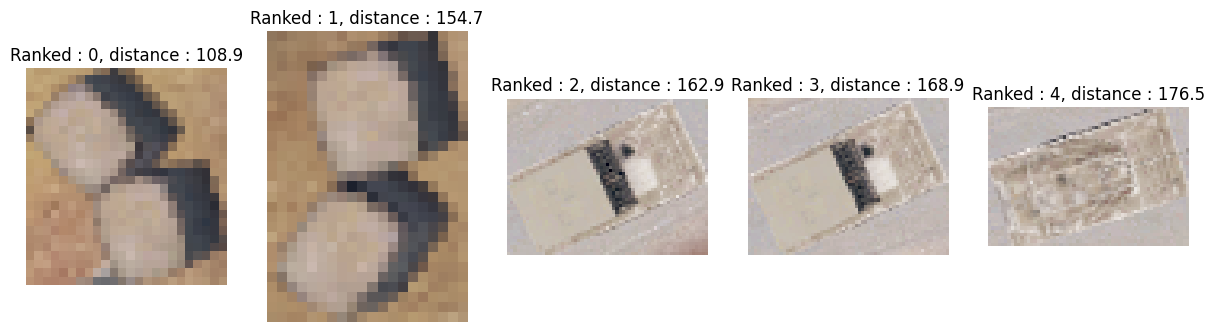

In [65]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 5, figsize=(15, 5))  # Set to 1 row and 5 columns

for index in range(5):
    distance = str(retrieved_examples["scores"][index])[0:5]
    axarr[index].set_title(f"Ranked : {index}, distance : {distance}" )
    axarr[index].imshow(retrieved_examples["images"]['image'][index])
    axarr[index].axis('off')

plt.show()
